### Installing external libraries

### Import Libraries

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import random
# import tensorflow.keras.utils
import torch
from torch import Tensor
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
import torch.utils.data as Data
import seaborn as sns
from datetime import datetime

# from torchprofile import profile_macs

# from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [4]:


# Set Random seed:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

gen = torch.Generator()
gen.manual_seed(seed)

### Model Parameters & Hyperparameters

In [5]:


#Model Parameters & Hyperparameters
log_run = False

params = dict(
    seed = seed,
    epochs = 10,
    batch_size = 256,
    lr = 0.0001,
    name = "RTN_norm",
    description = """Try the concat model with R=1/2 and with fading.""",
    k = 7,
    n = 21,
    A = 3.0,
    train_num = 1_000_000,
    val_num = 10_000,
    test_num =  1_000_000,
    fading = False,
    fading_sigma = 0.3,
    n_pilots = 0,
    estimation_network = "not required"
)

params["M"] = 2 ** params["k"] 
params["R"] = params["k"] / params["n"] 


### Model Structure

#### RTN norm

In [12]:


#RTN With norm
class RTNNorm(nn.Module):
    def __init__(self, in_channels: int, compressed_dim: int, fading: bool = False, f_sigma: float = 0.3) -> None:
      super(RTNNorm, self).__init__()
      self.in_channels = in_channels
      self.compressed_dim = compressed_dim
      self.fading = fading
      self.f_sigma = f_sigma

      self.encoder = self.build_encoder(self.in_channels, self.compressed_dim)
      
      self.decoder_input_normalizer = nn.LayerNorm(self.compressed_dim)
      
      self.decoder = self.build_decoder(self.compressed_dim, self.in_channels)

    def build_encoder(self, input_shape: int = 128, output_shape: int = 21) -> nn.Sequential:
      return nn.Sequential(
            nn.Linear(input_shape, 100),
            nn.BatchNorm1d(100),
            nn.Linear(100, output_shape),
            nn.BatchNorm1d(output_shape),
            )

    def build_decoder(self, input_shape: int = 21, output_shape: int = 128) -> nn.Sequential:
      return  nn.Sequential(
              nn.Linear(input_shape, 100),
              nn.LayerNorm(100),
              nn.Linear(100, output_shape),
              nn.LayerNorm(output_shape)
              )
    
    def mixedAWGN(self, x: Tensor, A: float) -> Tensor:
      shape = x.size()
      noise = torch.randn(shape, device = x.device)

      x_channel = torch.sigmoid(x) * A
      
      if self.fading:
        m3 = -self.f_sigma ** 2 / 2
        f_true = torch.empty(shape, device = x.device).log_normal_(m3, self.f_sigma)
        x_out = x_channel + (noise / f_true)
      else:
        x_out = x_channel + noise

      return x_out

    def get_constellation_points(self, x: Tensor, A: float) -> Tensor:
      encoded = self.encoder(x)
      x_channel = torch.sigmoid(encoded) * A
      return x_channel

    def forward(self, x: Tensor, A: float = 2.9) -> Tensor:
      encoded = self.encoder(x)

      signal = self.mixedAWGN(encoded, A)
      normalized_signal = self.decoder_input_normalizer(signal)

      decoded = self.decoder(normalized_signal)

      return decoded

#### Save Best

In [13]:


#Save Best
class SaveBestModel:
    def __init__(self, best_valid_loss: float =float('inf'), name: str = "best_model") -> None:
        self.best_valid_loss = best_valid_loss
        self.name = name
        
    def __call__(self, current_valid_loss: float, epoch: int, model: nn.Module, optimizer, criterion) -> None:
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"    Best validation loss: {self.best_valid_loss} - Saving best model for epoch: {epoch}")
            torch.save(model.state_dict(), f"./{self.name}.pth")

### Dataset

In [14]:


from torch.utils.data import Dataset
class CustomLoader(Dataset):

  def __init__(self, X,Y, target_transform=None):
    self.data = X
    self.label = Y
    self.transform = target_transform
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):

    data, label = self.data[idx], self.label[idx]

    if self.transform:
      data, label = self.transform(data), sself.transform(label)
    return data, label

In [33]:



from sklearn.model_selection import train_test_split


labels = torch.randint(params["M"], (params["train_num"]+params["val_num"],))
data = torch.eye(params["M"]).index_select(dim=0, index=labels)#[:, None, :]




X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
training_data = CustomLoader(X_train, y_train)
test_data = CustomLoader(X_test, y_test)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=params['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=params['batch_size'], shuffle=True)

### Training

In [16]:
x, y = next(iter(train_dataloader))
print(x.shape,y.shape)

torch.Size([256, 128]) torch.Size([256])


#### Setup model, loss, and optimizer

In [17]:
#Setup model, loss, and optimizer
model = RTNNorm(in_channels = params["M"], compressed_dim = params["n"], fading = params["fading"], f_sigma = params["fading_sigma"]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=params["lr"])
save_best = SaveBestModel(name = params['name'])

if log_run:
  run["config/model"] = type(model).__name__
  run["config/loss_fn"] = type(loss_fn).__name__
  run["config/optimizer"] = type(optimizer).__name__

In [18]:
# Saving model architecture to .txt
with open(f"./{params['name']}_structure.txt", "w") as f:
    f.write(str(model))

if log_run:
  run[f"io_files/artifacts/{params['name']}_structure"].upload(
      f"./{params['name']}_structure.txt"
  )

#### Training Cycle

In [39]:
#Training Cycle

load_best = torch.load(f"./{params['name']}.pth")
model.load_state_dict(load_best)

for epoch in range(1, params["epochs"] + 1):
  n_batches = len(train_dataloader)
  print(f"Epoch {epoch}/{params['epochs']}")
#   progress_bar = tensorflow.keras.utils.Progbar(target=n_batches, unit_name="batch")
  print(datetime.now())
  for step, (x, y) in enumerate(train_dataloader):
    x,y = x.to(device),y.to(device)
    x_decoded = model(x, params["A"])
    loss = loss_fn(x_decoded, y)

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 

    if log_run:
      run["training/batch/train_loss"].log(loss)
    
  with torch.no_grad():
    for _, (val_data,val_labels) in enumerate(test_dataloader):

      val_data, val_labels = val_data.to(device), val_labels.to(device)
      val_data_decoded = model(val_data, params["A"])
      val_loss = loss_fn(val_data_decoded, val_labels)


    save_best(val_loss, epoch, model, optimizer, loss_fn) 

    if log_run:
      run["training/batch/val_loss"].log(val_loss)  


# Save best model weight in Neptune run:
if log_run:
  run[f"io_files/artifacts/{params['name']}"].upload(
      f"./{params['name']}.pth"
  )

Epoch 1/10
2023-05-26 16:14:00.060921
Epoch 2/10
2023-05-26 16:14:09.919658
Epoch 3/10
2023-05-26 16:14:20.122399
Epoch 4/10
2023-05-26 16:14:30.215963
Epoch 5/10
2023-05-26 16:14:40.092687
Epoch 6/10
2023-05-26 16:14:50.067760
Epoch 7/10
2023-05-26 16:15:02.455804
Epoch 8/10
2023-05-26 16:15:14.585422
Epoch 9/10
2023-05-26 16:15:26.310748
Epoch 10/10
2023-05-26 16:15:36.965527


In [25]:
dense_model_size = get_model_size(model)
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has size=0.12 MiB


### Testing

In [26]:
#Testing
load_best = torch.load(f"./{params['name']}.pth")
model.load_state_dict(load_best)

<All keys matched successfully>

In [37]:
power = torch.arange(1, 11)
EpNo = 10 * torch.log10(power ** 2 / 4)
BLER = torch.zeros_like(power).float()
BER = torch.zeros_like(power).float()

output_model = []
with torch.no_grad():
  for i, A in enumerate(power):
    
    y_pred_model_output = []
    for x, y in test_dataloader:
      x, y= x.to(device), y.to(device)
      x_decoded = model(x, A)
      y_pred = torch.argmax(x_decoded, axis=1)
      y_pred_model_output.append(y_pred)
      error = torch.ne(y, y_pred).sum()
      BLER[i] += error.item() / params["test_num"]
    output_model.append(y_pred_model_output)
    BER[i] = 1 - (1 - BLER[i]) ** (1/params["k"])

    if log_run:
      run["testing/peak_intensity"].log(A)
      run["testing/EpNo(dB)"].log(EpNo[i])
      run["testing/BLER"].log(BLER[i])
      run["testing/BER"].log(BER[i])
    print(f'peak intensity = {power[i]:5.2f} | BLER = {BLER[i]:.7f} | BER = {BER[i]:.7f}')

peak intensity =  1.00 | BLER = 0.2230592 | BER = 0.0354136
peak intensity =  2.00 | BLER = 0.0257060 | BER = 0.0037134
peak intensity =  3.00 | BLER = 0.0003350 | BER = 0.0000479
peak intensity =  4.00 | BLER = 0.0000000 | BER = 0.0000000
peak intensity =  5.00 | BLER = 0.0000000 | BER = 0.0000000
peak intensity =  6.00 | BLER = 0.0000000 | BER = 0.0000000
peak intensity =  7.00 | BLER = 0.0000000 | BER = 0.0000000
peak intensity =  8.00 | BLER = 0.0000000 | BER = 0.0000000
peak intensity =  9.00 | BLER = 0.0000000 | BER = 0.0000000
peak intensity = 10.00 | BLER = 0.0000000 | BER = 0.0000000


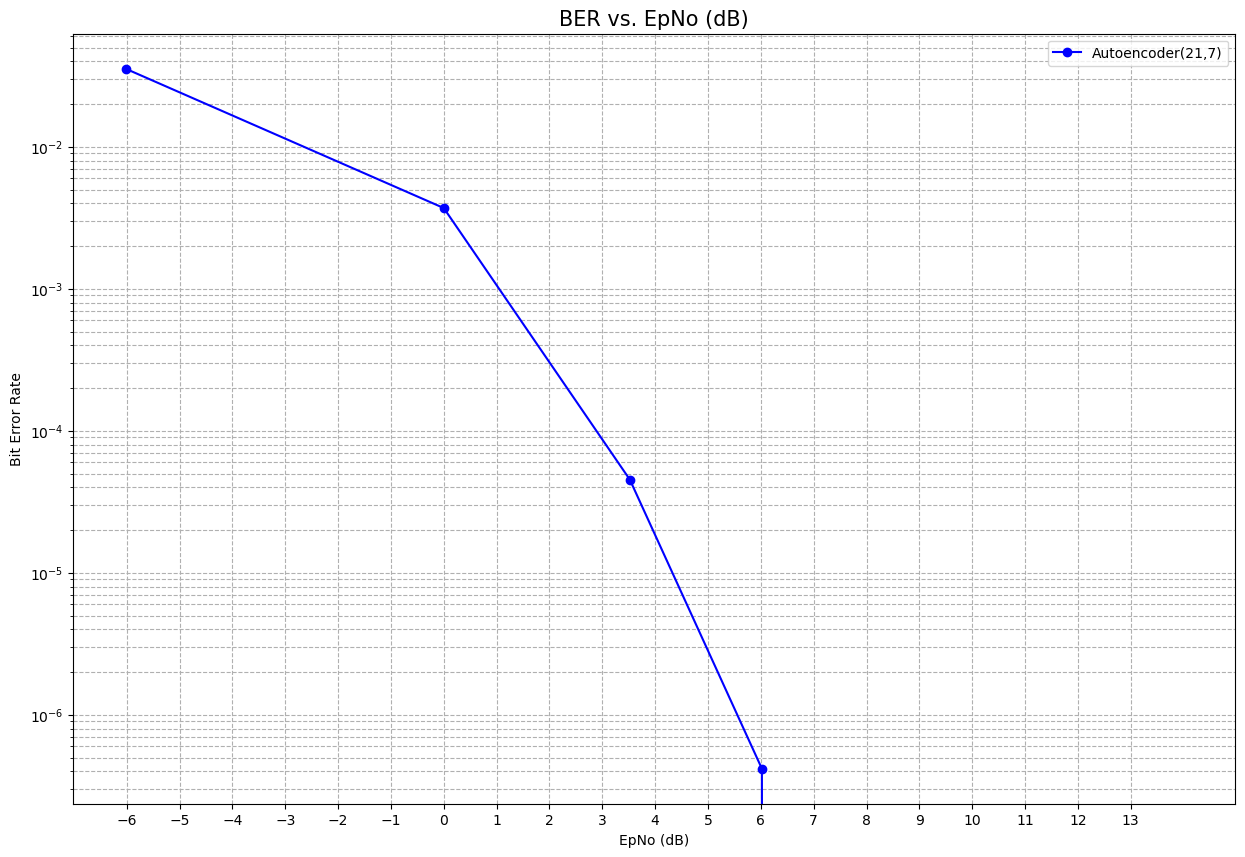

In [28]:


fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(EpNo.cpu(), BER.cpu(), 'bo-', label=f'Autoencoder({params["n"]},{params["k"]})')

ax.set_title('BER vs. EpNo (dB)', fontsize=15)
ax.set_xlabel('EpNo (dB)')
ax.set_ylabel('Bit Error Rate')

plt.yscale('log')
plt.grid(True, which="both", linestyle='--')
plt.legend(loc='upper right', ncol=1)
plt.xticks(np.arange(-6, max(EpNo)))

if log_run:
  run["val/BER_Curve"].upload(fig)

plt.show()

In [32]:
#Inference on Rpi

import numpy as np
import random
# import tensorflow.keras.utils
import torch
from torch import Tensor
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
import torch.utils.data as Data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#RTN With norm
class RTNNorm(nn.Module):
    def __init__(self, in_channels: int, compressed_dim: int, fading: bool = False, f_sigma: float = 0.3) -> None:
      super(RTNNorm, self).__init__()
      self.in_channels = in_channels
      self.compressed_dim = compressed_dim
      self.fading = fading
      self.f_sigma = f_sigma

      self.encoder = self.build_encoder(self.in_channels, self.compressed_dim)
      
      self.decoder_input_normalizer = nn.LayerNorm(self.compressed_dim)
      
      self.decoder = self.build_decoder(self.compressed_dim, self.in_channels)

    def build_encoder(self, input_shape: int = 128, output_shape: int = 21) -> nn.Sequential:
      return nn.Sequential(
            nn.Linear(input_shape, 100),
            nn.BatchNorm1d(100),
            nn.Linear(100, output_shape),
            nn.BatchNorm1d(output_shape),
            )

    def build_decoder(self, input_shape: int = 21, output_shape: int = 128) -> nn.Sequential:
      return  nn.Sequential(
              nn.Linear(input_shape, 100),
              nn.LayerNorm(100),
              nn.Linear(100, output_shape),
              nn.LayerNorm(output_shape)
              )
    
    def mixedAWGN(self, x: Tensor, A: float) -> Tensor:
      shape = x.size()
      noise = torch.randn(shape, device = x.device)

      x_channel = torch.sigmoid(x) * A
      
      if self.fading:
        m3 = -self.f_sigma ** 2 / 2
        f_true = torch.empty(shape, device = x.device).log_normal_(m3, self.f_sigma)
        x_out = x_channel + (noise / f_true)
      else:
        x_out = x_channel + noise

      return x_out

    def get_constellation_points(self, x: Tensor, A: float) -> Tensor:
      encoded = self.encoder(x)
      x_channel = torch.sigmoid(encoded) * A
      return x_channel

    def forward(self, x: Tensor, A: float = 2.9) -> Tensor:
      encoded = self.encoder(x)

      signal = self.mixedAWGN(encoded, A)
      normalized_signal = self.decoder_input_normalizer(signal)

      decoded = self.decoder(normalized_signal)

      return decoded

model = RTNNorm(128, 21, False, 0.3)

load_best = torch.load("/home/sathya/Desktop/data/wireless-model/RTN_norm.pth")
model.load_state_dict(load_best)
model = model.to("cpu")

In [33]:
model

RTNNorm(
  (encoder): Sequential(
    (0): Linear(in_features=128, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=100, out_features=21, bias=True)
    (3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder_input_normalizer): LayerNorm((21,), eps=1e-05, elementwise_affine=True)
  (decoder): Sequential(
    (0): Linear(in_features=21, out_features=100, bias=True)
    (1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=100, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
)

In [34]:
x_test = torch.load('/home/sathya/Desktop/data/wireless-model/X_test.pt')
y_test = torch.load('/home/sathya/Desktop/data/wireless-model/y_test.pt')
x_test, y_test = x_test.to(device), y_test.to(device)

In [35]:
print(x_test.shape)
test_input_data = x_test[:10,:]
print(test_input_data.shape)

torch.Size([333300, 128])
torch.Size([10, 128])


In [37]:
# model.qconfig = torch.ao.quantization.get_default_qconfig('qnn')

# create a quantized model instance
model_int8 = torch.ao.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# run the model
input_fp32 = test_input_data
res = model_int8(input_fp32)

In [40]:
torch.save(model_int8,'RTN_norm-dqint8.pth')

In [84]:
import time
def check_acc(orig_model, q_model, x_test, y_test):
    softmax = nn.Softmax(dim=1)
    models = [orig_model, q_model]
    ind = 0
    for model in models:
        model.eval()
        start = time.time_ns()
        output = torch.argmax(softmax(model(x_test)),dim=1)
        end_time = time.time_ns()
        in_correct = output[output!=y_test]
        percent_error = (len(in_correct)/len(y_test))*100
        model_name="Quantised Model" if ind==1 else "Orginal Model"
        print(model_name,"Metrics:","Incorrect Predictions:",percent_error, "Correct Predictions:", 100-percent_error )
        print("Time Consumption:", end_time-start,"ns")
        ind+=1

model = RTNNorm(128, 21, False, 0.3)
load_best = torch.load("/home/sathya/Desktop/data/wireless-model/RTN_norm.pth")
model.load_state_dict(load_best)
model_int8 = torch.load("/home/sathya/Desktop/Wireless-Comm-AutoEncoders/RTN_norm-dqint8.pth")

check_acc(model, model_int8, x_test, y_test)

Orginal Model Metrics: Incorrect Predictions: 0.15601560156015604 Correct Predictions: 99.84398439843984
Time Consumption: 325441052 ns
Quantised Model Metrics: Incorrect Predictions: 0.15901590159015902 Correct Predictions: 99.84098409840985
Time Consumption: 288687037 ns


In [85]:
print("Run Time Improvement:",(325441052 -288687037)/ (10 ** 9),"sec")

Run Time Improvement: 0.036754015 sec
